<a href="https://colab.research.google.com/github/GMoreno93/TEST_DATA_SCIENTIST/blob/main/Test_DATA_SCIENTIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cargar los datos (Enviados En la Prueba)
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving test_label.csv to test_label (1).csv
Saving test.csv to test (1).csv
Saving train_label.csv to train_label (1).csv
Saving train.csv to train (1).csv
User uploaded file "test_label.csv" with length 13700 bytes
User uploaded file "test.csv" with length 159039 bytes
User uploaded file "train_label.csv" with length 54725 bytes
User uploaded file "train.csv" with length 633841 bytes


In [2]:
# Con los Datos en el Colab se realiza la lectura como dataframes de pandas para facilitar el manejo de los datos
import pandas as pd
import numpy as np
df=pd.read_csv('/content/train.csv')
df['target'] =pd.read_csv('/content/train_label.csv',header=None)
df_test=pd.read_csv('/content/test.csv')
df_test['target'] =pd.read_csv('/content/test_label.csv',header=None)#Inspeccionando el dataset

In [3]:
len(df['d69'].unique())

2

In [4]:
# Verificamos la informacion en cada una de las variables para eliminar las variables que no tienen informacion o solo cuentan con un valor para todos los datos
import traceback
import re
from pandas import Series
x = df.dtypes.index
count = -1
print('Variables con solo un valor')
for i in x:
    if np.issubdtype(df[i], np.number) and len(df[i].unique()) > 1:
        count = count + 1
    else:   
        print(i)
        count = count + 1

Variables con solo un valor
d70


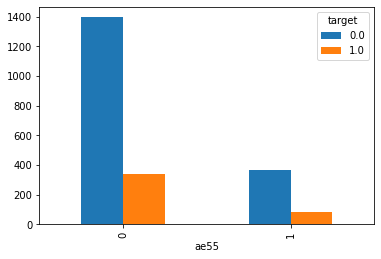

In [5]:
#Analisis de variables  
import matplotlib.pyplot as plt 
pd.crosstab (df['ae55'], df['target']) .plot (kind = 'bar') 

In [6]:
# Eliminamos las variables que tienen un solo valor la variable que no tiene nombre considerando que es un codigo relacionado con cada empresa
df_clean1=df.drop(['d70'], axis=1)
df_test_clean1=df.drop(['d70'], axis=1)
df_clean1=df_clean1.drop(['Unnamed: 0'], axis=1)
df_test_clean1=df_test_clean1.drop(['Unnamed: 0'], axis=1)

In [7]:
df_clean1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2189 entries, 0 to 2188
Data columns (total 71 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   v0      2189 non-null   float64
 1   v1      2189 non-null   float64
 2   v2      2189 non-null   float64
 3   v3      2189 non-null   float64
 4   v4      2189 non-null   float64
 5   v5      2189 non-null   float64
 6   v6      2189 non-null   float64
 7   v7      2189 non-null   float64
 8   v8      2189 non-null   float64
 9   v9      2189 non-null   float64
 10  v10     2189 non-null   float64
 11  v11     2189 non-null   float64
 12  v12     2189 non-null   float64
 13  v13     2189 non-null   float64
 14  v14     2189 non-null   float64
 15  v15     2189 non-null   float64
 16  v16     2189 non-null   float64
 17  v17     2189 non-null   float64
 18  v18     2189 non-null   float64
 19  v19     2189 non-null   float64
 20  v20     2189 non-null   float64
 21  v21     2189 non-null   float64
 22  

In [8]:
# Funcion para hacer WOE and IV
import pandas as pd
import numpy as np
import pandas.core.algorithms as algos
import scipy.stats.stats as stats
import string

max_bin = 20
force_bin = 3

#binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["Valor_Min"] = d2.min().X
    d3["Valor_Max"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'Valor_Min':np.nan},index=[0])
        d4["Valor_Max"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','Valor_Min', 'Valor_Max', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def data_vars(df1, target):
    
   
    x = df1.dtypes.index
    count = -1
    print('Variables que tienen maximo 2 valores')
    for i in x:
        if np.issubdtype(df1[i], np.number) and len(df1[i].unique()) > 2:
            conv = mono_bin(target, df1[i])
            conv["VAR_NAME"] = i
            count = count + 1
        else:
          print(i)
        if count == 0:
            iv_df = conv
        else:
            iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [9]:
final_iv, IV = data_vars (df_clean1, df_clean1.target)

Variables que tienen maximo 2 valores
v28
v29
v31
v32
tcs37
tcs38
tcs39
tcs40
tcs41
tcs42
tc43
tc44
tc45
tc46
tc47
tc48
tc49
tc50
tc51
tc52
tc53
dv54
ae55
ae56
ae57
ae58
ae59
ae60
ae61
ae62
ae63
ae64
ae65
ae66
ae67
ae68
d69
target


In [10]:
final_iv

,VAR_NAME,Valor_Min,Valor_Max,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,v0,0.00,0.000000e+00,2139,381.0,0.178121,1758.0,0.821879,0.888112,0.998864,-0.117521,0.521329
1,v0,7788.00,5.030246e+06,50,48.0,0.960000,2.0,0.040000,0.111888,0.001136,4.589666,0.521329
2,v1,0.00,1.781006e+05,1095,164.0,0.149772,931.0,0.850228,0.382284,0.528977,-0.324781,0.087415
3,v1,178226.23,1.257078e+07,1094,265.0,0.242230,829.0,0.757770,0.617716,0.471023,0.271122,0.087415
4,v2,0.00,1.000000e+00,165,64.0,0.387879,101.0,0.612121,0.149184,0.057386,0.955375,0.097107
...,...,...,...,...,...,...,...,...,...,...,...,...
145,v36,59.00,7.310000e+02,86,5.0,0.058140,81.0,0.941860,0.011655,0.046023,-1.373399,0.048417
146,v36,-3.00,3.100000e+01,2103,424.0,0.201617,1679.0,0.798383,0.988345,0.953977,0.035392,0.048417
147,v36,59.00,7.310000e+02,86,5.0,0.058140,81.0,0.941860,0.011655,0.046023,-1.373399,0.048417
148,v36,-3.00,3.100000e+01,2103,424.0,0.201617,1679.0,0.798383,0.988345,0.953977,0.035392,0.048417


In [11]:
# Variables para las que se realizó WOE 
final_iv['VAR_NAME'].unique()

array(['v0', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10',
       'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19',
       'v20', 'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v30',
       'v33', 'v34', 'v35', 'v36'], dtype=object)

In [12]:
#Creamos Las nuevas variables 
transform_vars_list = final_iv['VAR_NAME'].unique()
transform_prefix = 'new_' 
for var in transform_vars_list:
    small_df = final_iv[final_iv['VAR_NAME'] == var]
    transform_dict = dict(zip(small_df.Valor_Max,small_df.WOE))
    replace_cmd = ''
    replace_cmd1 = ''
    for i in sorted(transform_dict.items()):
        replace_cmd = replace_cmd + str(i[1]) + str(' if x <= ') + str(i[0]) + ' else '
        replace_cmd1 = replace_cmd1 + str(i[1]) + str(' if x == "') + str(i[0]) + '" else '
    replace_cmd = replace_cmd + '0'
    replace_cmd1 = replace_cmd1 + '0'
    if replace_cmd != '0':
        try:
            df_clean1[transform_prefix + var] = df_clean1[var].apply(lambda x: eval(replace_cmd))
            df_test_clean1[transform_prefix + var] = df_test_clean1[var].apply(lambda x: eval(replace_cmd))
        except:
            df_clean1[transform_prefix + var] = df_clean1[var].apply(lambda x: eval(replace_cmd1))
            df_test_clean1[transform_prefix + var] = df_test_clean1[var].apply(lambda x: eval(replace_cmd1))

In [13]:
#variable que contiene las nuevas WOE y eliminamos las anteriores
df_clean2=df_clean1
df_test_clean2=df_test_clean1
df_clean2=df_clean2.drop(final_iv['VAR_NAME'].unique(), axis=1)
df_test_clean2=df_test_clean2.drop(final_iv['VAR_NAME'].unique(), axis=1)

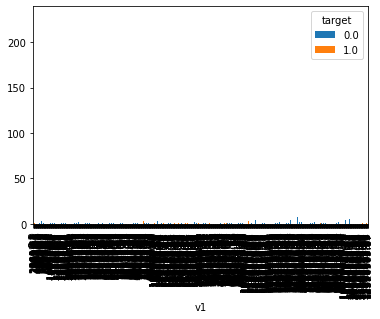

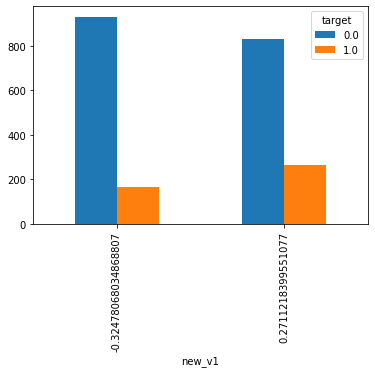

In [14]:
import matplotlib.pyplot as plt 
pd.crosstab (df['v1'], df_clean2['target']) .plot (kind = 'bar') 
pd.crosstab (df_clean2['new_v1'], df_clean2['target']) .plot (kind = 'bar') 

In [15]:
X_train=np.array(df_clean2.drop(['target'], axis=1))
Y_train = np.array(df_clean2['target'])
X_test=np.array(df_test_clean2.drop(['target'], axis=1))
Y_test = np.array(df_test_clean2['target'])

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

escalar = StandardScaler()
X_train = escalar.fit_transform(X_train)
X_test = escalar.transform(X_test)
algoritmo = LogisticRegression(class_weight=[0.5,1],max_iter=10000)
algoritmo.fit(X_train, Y_train)


LogisticRegression(C=1.0, class_weight=[0.5, 1], dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
y_pred = algoritmo.predict(X_test)

In [18]:
#Calculo de Metricas de evaluacion del modelo
from sklearn.metrics import confusion_matrix
matriz = confusion_matrix(Y_test, y_pred)
print('Matriz de Confusión:')
print(matriz)
#Calculo la precisión del modelo
from sklearn.metrics import precision_score
precision = precision_score(Y_test, y_pred)
print('Precisión del modelo:')
print(precision)
#Calculo la sensibilidad del modelo
from sklearn.metrics import recall_score
sensibilidad = recall_score(Y_test, y_pred)
print('Sensibilidad del modelo:')
print(sensibilidad)
#Calculo el Puntaje F1 del modelo
from sklearn.metrics import f1_score
puntajef1 = f1_score(Y_test, y_pred)
print('Puntaje F1 del modelo:')
print(puntajef1)
#Calculo la curva ROC - AUC del modelo
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(Y_test, y_pred)
print('Curva ROC - AUC del modelo:')
print(roc_auc)

Matriz de Confusión:
[[1651  109]
 [ 131  298]]
Precisión del modelo:
0.7321867321867321
Sensibilidad del modelo:
0.6946386946386947
Puntaje F1 del modelo:
0.7129186602870813
Curva ROC - AUC del modelo:
0.8163534382284383


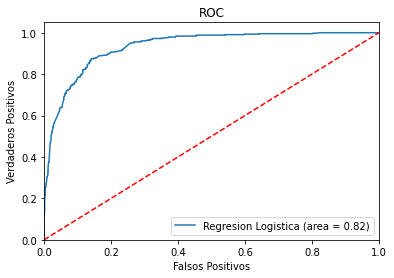

In [19]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(Y_test, algoritmo.predict(X_test))
fpr, tpr, thresholds = roc_curve(Y_test, algoritmo.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Regresion Logistica (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falsos Positivos')
plt.ylabel('Verdaderos Positivos')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()